In [24]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load the data acquired using TIINGO

In [2]:
g_df = pd.read_csv("/Users/abhay/Desktop/qbp_prep/pairs_trading/GOOG.csv")
gl_df = pd.read_csv("/Users/abhay/Desktop/qbp_prep/pairs_trading/GOOGL.csv")

In [8]:
data = pd.DataFrame(
    {
        'GOOG': g_df['adjClose'],
        'GOOGL': gl_df['adjClose']
    }
)
stock_g = data['GOOG']
stock_gl = data['GOOGL']

## Calculate the Spread and Z-Score

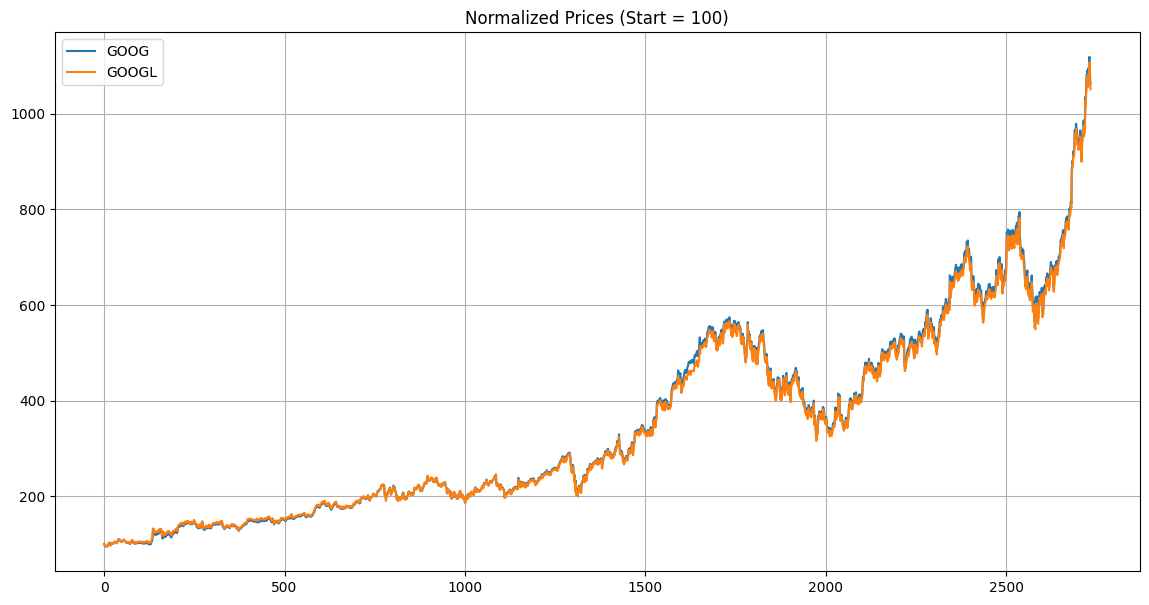

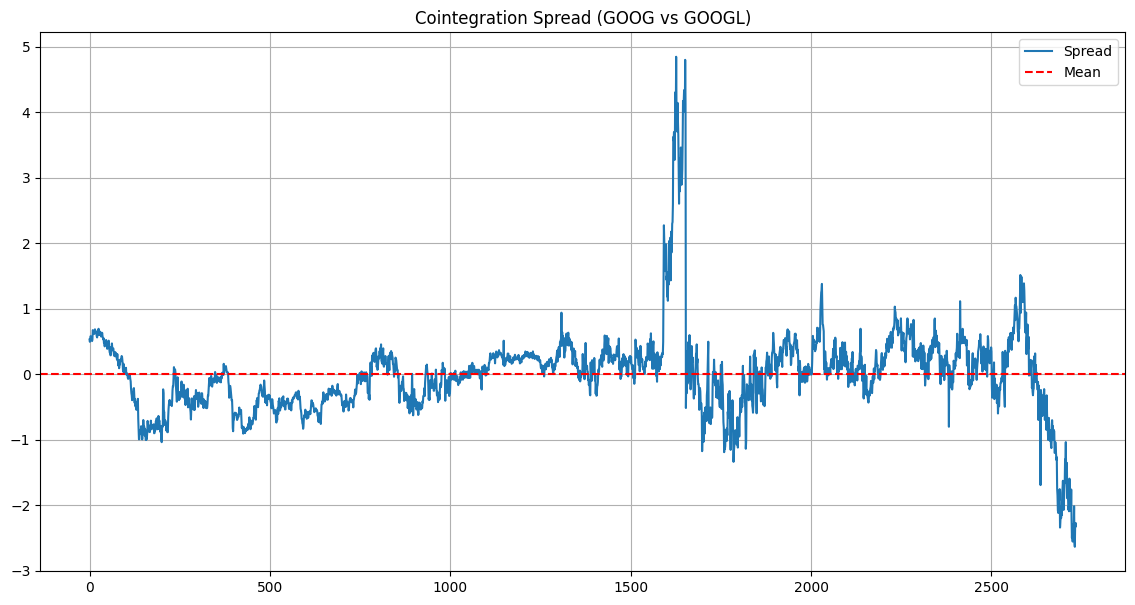

In [13]:

normalized_a = (stock_g / stock_g.iloc[0]) * 100
normalized_b = (stock_gl / stock_gl.iloc[0]) * 100

plt.figure(figsize=(14, 7))
plt.title('Normalized Prices (Start = 100)')
plt.plot(normalized_a, label='GOOG')
plt.plot(normalized_b, label='GOOGL')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: The Spread ---
# To find the spread, we run a regression: stock_a = hedge_ratio * stock_b + intercept
# The spread is the residual (error) of this regression

# Add a constant (intercept) to the regressor
stock_b_with_const = sm.add_constant(stock_gl)

# Run the OLS (Ordinary Least Squares) regression
model = sm.OLS(stock_g, stock_b_with_const)
results = model.fit()

# The 'hedge_ratio' is the coefficient for 'GOOGL' beta
hedge_ratio = results.params['GOOGL']

# Calculate the spread: Spread = GOOG - (hedge_ratio * GOOGL)
spread = results.resid

plt.figure(figsize=(14, 7))
plt.title('Cointegration Spread (GOOG vs GOOGL)')
plt.plot(spread, label='Spread')

# Plot the mean line
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')

plt.legend()
plt.grid(True)
plt.show()

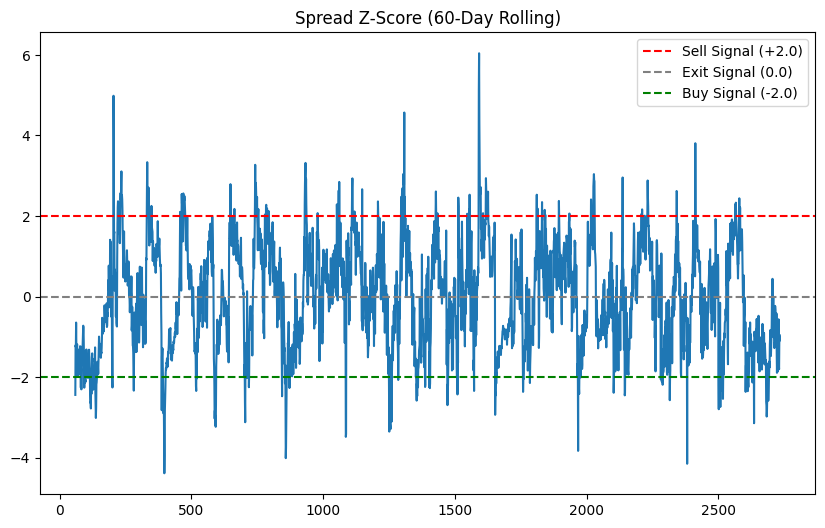

In [15]:
# calculate z-score using rolling window
# this is the signal. it shows how strectedh the spread is
# lets take a 60 day window
window_size = 60 # Use a 60-day (approx. 3 month) lookback
rolling_mean = spread.rolling(window=window_size).mean()
rolling_std = spread.rolling(window=window_size).std()

# Calculate the Z-Score
z_score = (spread - rolling_mean) / rolling_std

z_score.plot(figsize=(10, 6), title='Spread Z-Score (60-Day Rolling)')
plt.axhline(2.0, color='red', linestyle='--', label='Sell Signal (+2.0)')
plt.axhline(0.0, color='gray', linestyle='--', label='Exit Signal (0.0)')
plt.axhline(-2.0, color='green', linestyle='--', label='Buy Signal (-2.0)')
plt.legend()
plt.show()

# Add to our main dataframe
data['z_score'] = z_score

## Backtesting and Plotting profit and loss

Trading Signals:
- Entry Threshold (e.g., 2.0):If Z-Score > 2.0: The spread is too high. Short the pair (Short A, Long $\beta$ units of B).If Z-Score < -2.0: The spread is too low. Long the pair (Long A, Short $\beta$ units of B).
- Exit Threshold (e.g., 0.0):If you are in a position and the Z-Score crosses 0.0: The spread has reverted to the mean. Close the position and take the profit

In [22]:
data

,GOOG,GOOGL,z_score
0,26.060951,26.294916,NaN
1,25.517694,25.793895,NaN
2,24.926269,25.157315,NaN
3,24.883563,25.083329,NaN
4,24.962022,25.170722,NaN
...,...,...,...
2730,290.590000,290.100000,-1.701792
2731,291.740000,291.310000,-1.806656
2732,287.430000,286.710000,-1.004658
2733,279.120000,278.570000,-1.103157



--- Backtest Complete ---
Total P&L: $10.34


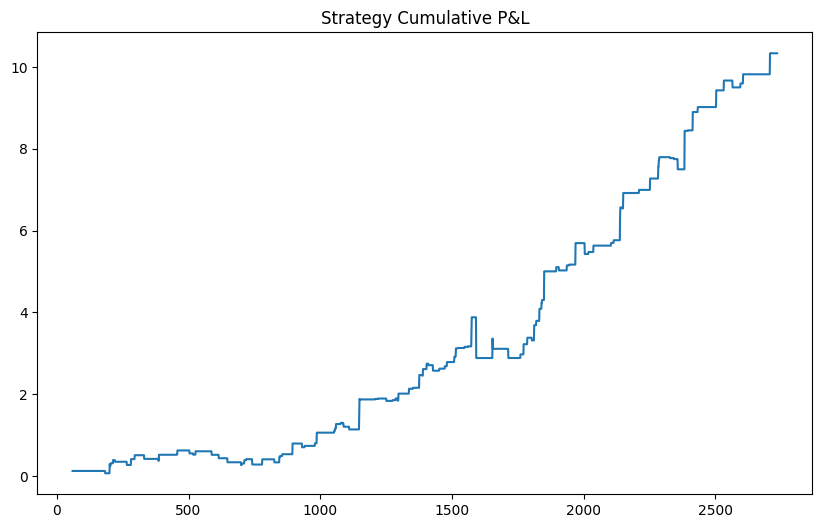


--- Final Performance Metrics ---
Total P&L: $10.34
Annualized Sharpe Ratio: 1.26
Maximum Drawdown: $1.00


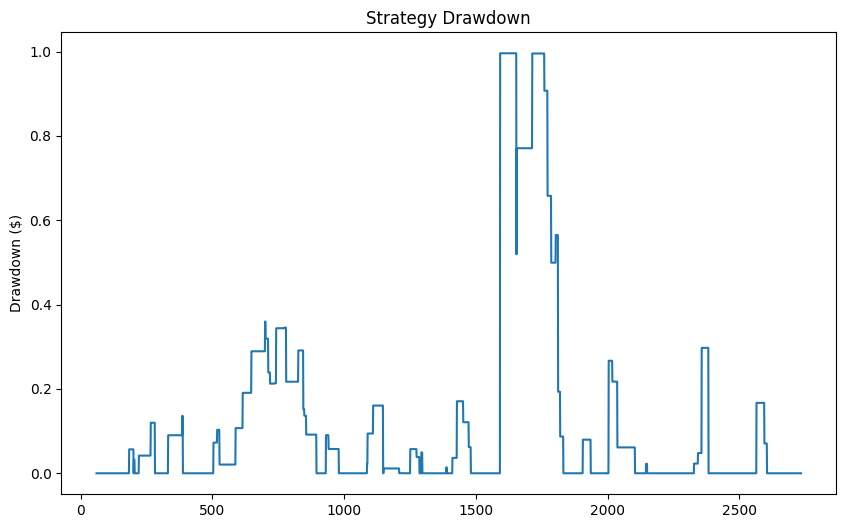

In [27]:

model = sm.OLS(stock_g, sm.add_constant(stock_gl))
results = model.fit()
beta = results.params['GOOGL']
#  doing backtest
# We'll use simple 1-share logic 
positions = pd.DataFrame(index=data.index).fillna(0.0)
portfolio = pd.DataFrame(index=data.index).fillna(0.0)

positions['GOOG'] = 0.0
positions['GOOGL'] = 0.0
portfolio['returns'] = 0.0
# Store position state (0 = no position, 1 = long spread, -1 = short spread)
position_state = 0 
entry_threshold = 2.0
exit_threshold = 0.0


for i in range(1, len(data)):
    z = data['z_score'].iloc[i]
    
    # Case 1: Z-Score is very low (<-2.0). Buy the spread (Long A, Short B)
    if z < -entry_threshold and position_state == 0:
        position_state = 1 # We are now "long" the spread
        positions['GOOG'].iloc[i] = 1
        positions['GOOGL'].iloc[i] = -beta
    
    # Case 2: Z-Score is very high (>+2.0). Short the spread (Short A, Long B)
    elif z > entry_threshold and position_state == 0:
        position_state = -1 # We are now "short" the spread
        # Record the "trades"
        positions['GOOG'].iloc[i] = -1
        positions['GOOGL'].iloc[i] = beta
        
    
    # Case 3: We are long and Z-Score crosses back to 0. Exit for profit.
    elif z > -exit_threshold and position_state == 1:
        position_state = 0 # Close position
        positions['GOOG'].iloc[i] = -1
        positions['GOOGL'].iloc[i] = beta
    
    # Case 4: We are short and Z-Score crosses back to 0. Exit for profit.
    elif z < exit_threshold and position_state == -1:
        position_state = 0 # Close position
        positions['GOOG'].iloc[i] = 1
        positions['GOOGL'].iloc[i] = -beta

# Calculate returns
# Get daily price changes
price_changes = data.diff().dropna()
# 'positions' has a 1-day lag, so shift it to align with *today's* price change
trade_positions = positions.shift(1).dropna()

# Calculate daily P&L
portfolio['returns'] = (trade_positions['GOOG'] * price_changes['GOOG']) + \
                       (trade_positions['GOOGL'] * price_changes['GOOGL'])

# Plot the "Resume-Worthy" P&L Chart
portfolio['cumulative_pnl'] = portfolio['returns'].cumsum()

print("\n--- Backtest Complete ---")
print(f"Total P&L: ${portfolio['cumulative_pnl'].iloc[-1]:.2f}")

portfolio['cumulative_pnl'].plot(figsize=(10, 6), title='Strategy Cumulative P&L')
plt.show()

# compute metrics
daily_pnl = portfolio['returns']

# --- Sharpe Ratio ---
# 252 trading days in a year
# assume risk-free rate is 0 for simplicity
mean_daily_pnl = daily_pnl.mean()
std_daily_pnl = daily_pnl.std()

# annualized Sharpe Ratio
sharpe_ratio = (mean_daily_pnl / std_daily_pnl) * np.sqrt(252)

# --- Max Drawdown ---
# Calculate the cumulative P&L
cumulative_pnl = portfolio['cumulative_pnl']

# 1. Calculate the running maximum P&L
running_max = cumulative_pnl.cummax()

# 2. Calculate the drawdown (difference between running max and current P&L)
drawdown = running_max - cumulative_pnl

# 3. Find the largest drawdown
max_drawdown = drawdown.max()


print(f"\n--- Final Performance Metrics ---")
print(f"Total P&L: ${cumulative_pnl.iloc[-1]:.2f}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: ${max_drawdown:.2f}")

# Plot the drawdown
drawdown.plot(figsize=(10, 6), title='Strategy Drawdown')
plt.ylabel('Drawdown ($)')
plt.show()


## Scaling backtesting for $10,000 capital

- holdings = the shares we own

In [29]:
#Run the Backtest (with $10,000 Capital) 
capital = 10000.0
# This DataFrame will store the NUMBER of shares we hold each day
holdings = pd.DataFrame(index=data.index).fillna(0.0)
holdings['GOOG'] = 0.0
holdings['GOOGL'] = 0.0

# Store cash P&L
portfolio = pd.DataFrame(index=data.index).fillna(0.0)
portfolio['returns'] = 0.0

# We still use position_state to track if we are in a trade
# 0 = flat, 1 = long spread, -1 = short spread
position_state = 0 
entry_threshold = 2.0
exit_threshold = 0.0

# These vars will store the number of shares we are currently holding
current_goog_shares = 0
current_googl_shares = 0

print("Running backtest with $10,000 capital...")

for i in range(1, len(data)):
    # Get today's z-score and prices
    z = data['z_score'].iloc[i]
    goog_price = data['GOOG'].iloc[i]
    
    # --- Checking for new trade entries ---
    
    # Case 1: Z-Score is very low (<-2.0). Go LONG the spread
    # (Long GOOG, Short GOOGL)
    if z < -entry_threshold and position_state == 0:
        position_state = 1 # We are now "long" the spread
        
        # Calculate shares. We allocate $10k to the long leg (GOOG)
        current_goog_shares = capital / goog_price
        current_googl_shares = -beta * current_goog_shares # Hedge with short GOOGL
        
    # Case 2: Z-Score is very high (>+2.0). Go SHORT the spread
    # (Short GOOG, Long GOOGL)
    elif z > entry_threshold and position_state == 0:
        position_state = -1 # We are now "short" the spread
        
        # Calculate shares. We allocate $10k to the short leg (GOOG)
        current_goog_shares = -capital / goog_price # Short GOOG
        current_googl_shares = -beta * current_goog_shares # Hedge with long GOOGL
        
    # --- Checking for trade exits ---
    
    # Case 3: We are LONG and Z-Score crosses back to 0.
    elif z > -exit_threshold and position_state == 1:
        position_state = 0 # Close position
        current_goog_shares = 0
        current_googl_shares = 0
    
    # Case 4: We are SHORT and Z-Score crosses back to 0. Exit.
    elif z < exit_threshold and position_state == -1:
        position_state = 0 # Close position
        current_goog_shares = 0
        current_googl_shares = 0
    
    holdings['GOOG'].iloc[i] = current_goog_shares
    holdings['GOOGL'].iloc[i] = current_googl_shares

print("Backtest loop complete. Calculating P&L...")

Running backtest with $10,000 capital...
Backtest loop complete. Calculating P&L...



--- Backtest Complete ($10k Capital) ---
Total P&L: $2042.37


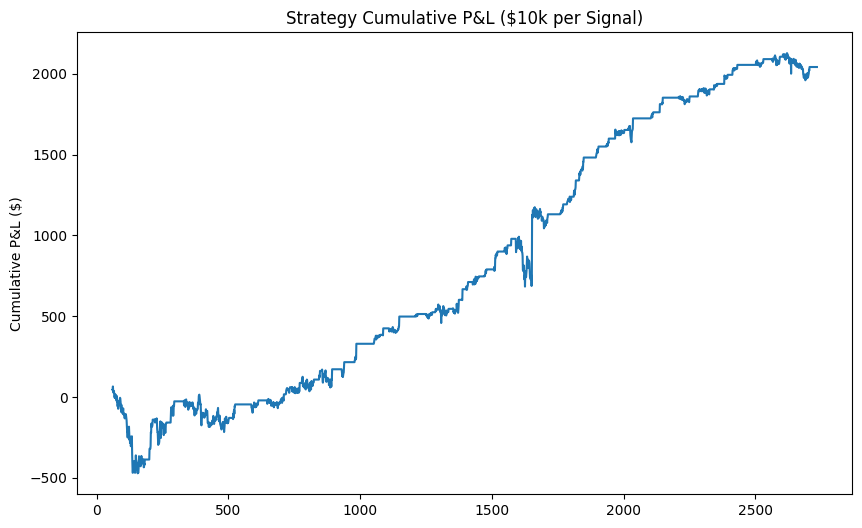

In [31]:
# Calculate P&L and Plot 

# Get daily price changes
price_changes = data.diff().dropna()

# Get *yesterday's* holdings to calculate *today's* P&L
# This is the correct way to avoid lookahead bias
positions_held = holdings.shift(1).dropna()

# Ensure indexes align after dropping NaNs
common_index = price_changes.index.intersection(positions_held.index)
price_changes = price_changes.loc[common_index]
positions_held = positions_held.loc[common_index]

# Calculate daily P&L
portfolio['returns'] = (positions_held['GOOG'] * price_changes['GOOG']) + \
                       (positions_held['GOOGL'] * price_changes['GOOGL'])

# remoev NANs
portfolio = portfolio.dropna()

portfolio['cumulative_pnl'] = portfolio['returns'].cumsum()

print(f"\n--- Backtest Complete ($10k Capital) ---")
print(f"Total P&L: ${portfolio['cumulative_pnl'].iloc[-1]:.2f}")

portfolio['cumulative_pnl'].plot(figsize=(10, 6), 
                                 title='Strategy Cumulative P&L ($10k per Signal)')
plt.ylabel('Cumulative P&L ($)')
plt.show()


--- Final Performance Metrics ($10k Capital) ---
Total P&L: $2042.37
Annualized Sharpe Ratio: 0.74
Maximum Drawdown: $537.27


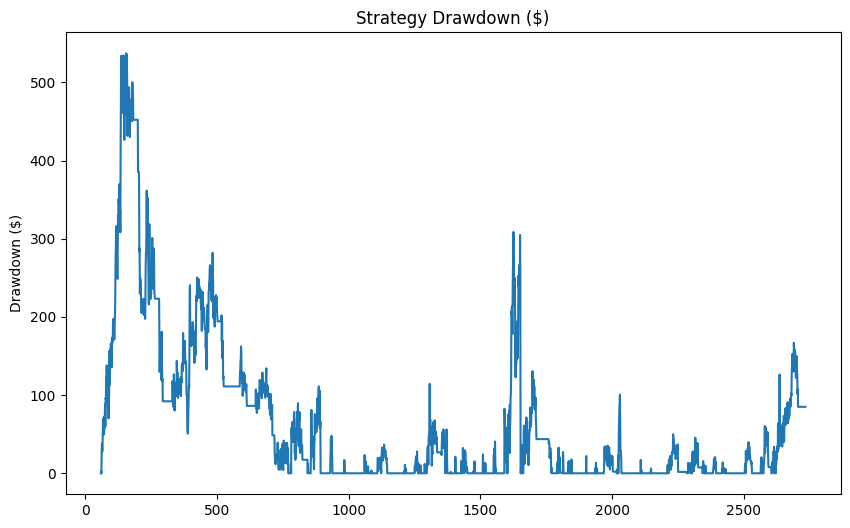

In [32]:
#  Performance Metrics (on $10k P&L) 

daily_pnl = portfolio['returns']

# --- Sharpe Ratio ---
mean_daily_pnl = daily_pnl.mean()
std_daily_pnl = daily_pnl.std()
sharpe_ratio = (mean_daily_pnl / std_daily_pnl) * np.sqrt(252)

# --- Max Drawdown ---
cumulative_pnl = portfolio['cumulative_pnl']
running_max = cumulative_pnl.cummax()
drawdown = running_max - cumulative_pnl
max_drawdown = drawdown.max()

# --- Print Final Report ---
print(f"\n--- Final Performance Metrics ($10k Capital) ---")
print(f"Total P&L: ${cumulative_pnl.iloc[-1]:.2f}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: ${max_drawdown:.2f}")

# Plot the drawdown
drawdown.plot(figsize=(10, 6), title='Strategy Drawdown ($)')
plt.ylabel('Drawdown ($)')
plt.show()